In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, PrecisionRecallDisplay, roc_curve, auc
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.feature_selection import SelectFromModel, RFE,RFECV
from sklearn.pipeline import Pipeline
import os
import other_ml_models
from comet_ml import Experiment
from comet_ml.integration.sklearn import log_model
from feature_engineering import FeatureEngineering
%matplotlib inline

In [9]:
pd.set_option('display.max_columns', 500)

In [3]:
df_train, df_test = FeatureEngineering("data/all_game_data_milesstone_2.csv").train_test_split()

Split into Train and Validation sets

In [4]:
train_cols = ['x_coordinate', 'y_coordinate', 'last_x_coordinate',
       'last_y_coordinate', 'distance_from_last_event',
       'rebound', 'speed', 'time_since_powerplay_started',
       'num_friendly_non_goalie_skaters', 'num_opposing_non_goalie_skaters',
       'is_emptyNet', 'shot_type', 'shot_distance_to_goal',
       'shot_angle', 'change_in_shot_angle']

X = df_train[train_cols]
y = df_train["is_goal"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42)

# KNN

## Create Pipeline

In [7]:
experiment = Experiment(
  api_key=os.environ.get("COMET_API_KEY"),
  project_name="nhl-data-science",
  workspace="mahmoodhegazy"
)

[experiment.log_dataset_hash(data_set) for data_set in [X_train, X_test, y_train, y_test]]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/mahmoodhegazy/nhl-data-science/b80593d676374abb90be80dd5f748c5a



[None, None, None, None]

In [10]:
knn_clf=KNeighborsClassifier(n_neighbors='n_neighbors', weights='weights', metric='metric', algorithm="algorithm")
recursive_cv_feature_selection = RFECV( min_features_to_select='min_features_to_select',estimator=LinearRegression())
knn_pipe = other_ml_models.create_pipeline(classifier=knn_clf,feature_selection=recursive_cv_feature_selection)

In [11]:
knn_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Numerical_transform',
                                                  Pipeline(steps=[('Impt',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16f44e610>),
                                                 ('Categorical_transform',
                                                  Pipeline(steps=[('Impt',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncod...own='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16f44f8d0>)])),
                ('feature_select',
                 RFECV(estimator=LinearRegression(),
                       min_features_to_select='min_features_to_select')),
                ('classifier',
                 KNeighborsClassifier(algorithm='algorithm', metric='metric',
                                      n_neighbors='n_neighbors',
                                      weights='weights'))])

## Grid Search Hyperparamtuning

In [12]:
param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 11],  # numbers of neighbors
    'classifier__weights': ['uniform', 'distance'],  # weight function used in prediction
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski'],  # the distance metric
    'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree'],  # algorithm used to compute the nearest neighbors
    'feature_select__min_features_to_select': [1,2,3,None],
}

# Fit a 3-fold GridSearchCV
knn_gs = GridSearchCV(knn_pipe, param_grid, cv=3, verbose=1, n_jobs=-1)
knn_gs.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters:")
print(knn_gs.best_params_)
print("Grid scores:")
means = knn_gs.cv_results_['mean_test_score']
stds = knn_gs.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, knn_gs.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Fitting 3 folds for each of 288 candidates, totalling 864 fits


/Users/mahmoodhegazy/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/mahmoodhegazy/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
216 fits failed out of a total of 864.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
216 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/mahmoodhegazy/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  Fil

Best parameters:
{'classifier__algorithm': 'auto', 'classifier__metric': 'euclidean', 'classifier__n_neighbors': 11, 'classifier__weights': 'uniform', 'feature_select__min_features_to_select': 1}
Grid scores:
0.909 (+/-0.002) for {'classifier__algorithm': 'auto', 'classifier__metric': 'euclidean', 'classifier__n_neighbors': 3, 'classifier__weights': 'uniform', 'feature_select__min_features_to_select': 1}
0.909 (+/-0.002) for {'classifier__algorithm': 'auto', 'classifier__metric': 'euclidean', 'classifier__n_neighbors': 3, 'classifier__weights': 'uniform', 'feature_select__min_features_to_select': 2}
0.909 (+/-0.002) for {'classifier__algorithm': 'auto', 'classifier__metric': 'euclidean', 'classifier__n_neighbors': 3, 'classifier__weights': 'uniform', 'feature_select__min_features_to_select': 3}
nan (+/-nan) for {'classifier__algorithm': 'auto', 'classifier__metric': 'euclidean', 'classifier__n_neighbors': 3, 'classifier__weights': 'uniform', 'feature_select__min_features_to_select': No

Train on best Hyperparams

In [13]:
knn_pipe_best = knn_gs.best_estimator_
knn_pipe_best.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Numerical_transform',
                                                  Pipeline(steps=[('Impt',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16f726450>),
                                                 ('Categorical_transform',
                                                  Pipeline(steps=[('Impt',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16f725a10>)])),
                ('feature_select', RFECV(estimator=LinearRegression())),
                ('classifier',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=11))])

## Logging Validation Scores

In [14]:
preds = knn_pipe_best.predict(X_test)
preds_train = knn_pipe_best.predict(X_train)

print("Accuracy (train): ", accuracy_score(y_train,preds_train))
print("Accuracy (test): ", accuracy_score(y_test,preds))
print("Classification report:\n", classification_report(y_test,preds))

Accuracy (train):  0.9270164497421662
Accuracy (test):  0.9243621347154626
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96     43126
           1       0.76      0.25      0.38      4337

    accuracy                           0.92     47463
   macro avg       0.84      0.62      0.67     47463
weighted avg       0.91      0.92      0.91     47463



In [15]:
preds_prob = knn_pipe_best.predict_proba(X_test)

{'web': 'https://www.comet.com/api/image/download?imageId=ef68a2c55ddc4cef917650eef354dd93&experimentKey=b80593d676374abb90be80dd5f748c5a',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=ef68a2c55ddc4cef917650eef354dd93&experimentKey=b80593d676374abb90be80dd5f748c5a',
 'imageId': 'ef68a2c55ddc4cef917650eef354dd93'}

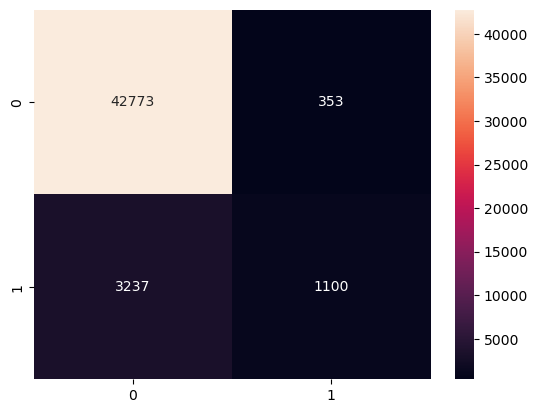

In [16]:
cm=confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True,fmt="d")
experiment.log_figure(figure_name='Confusion Matrix', step=None)

In [17]:
metrics = {"accuracy": accuracy_score(y_test, preds), "f1": f1_score(y_test, preds), "recall": recall_score(y_test, preds), "precision": precision_score(y_test, preds)}
parameter = {
    "model_type": 'Random Forest',
    "param_grid": str(knn_pipe_best.get_params()),
}
experiment.log_parameters(parameter)
experiment.log_metrics(metrics)

COMET WARNING: truncated string; too long: '{'memory': None, 'steps': [('preprocessor', ColumnTransformer(transformers=[('Numerical_transform',
                                 Pipeline(steps=[('Impt', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x16f726450>),
                                ('Categorical_transform',
                                 Pipeline(steps=[('Impt',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x16f725a10>)])), ('featu

### Prec-Recall Curve

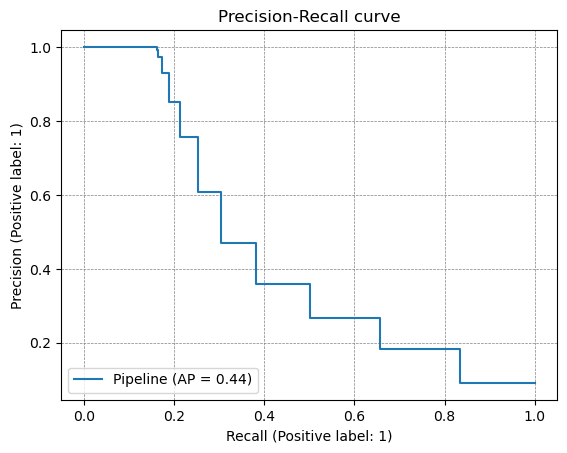

In [18]:
other_ml_models.plot_precision_recall(model=knn_pipe_best, X_test=X_test, y_test=y_test, experiment=experiment)

### ROC Curve

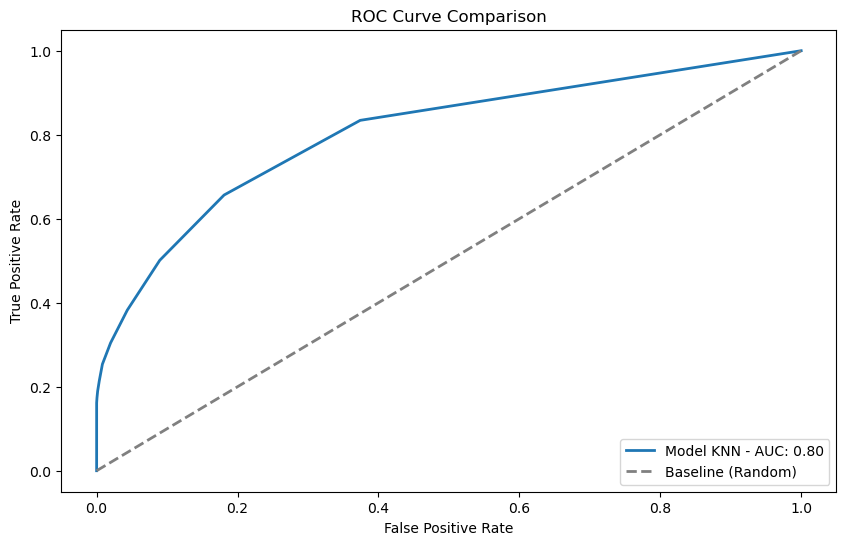

In [29]:
plt.figure(figsize=(10, 6))
line_width = 2

false_positive_rate, true_positive_rate, _ = roc_curve(y_test.ravel(),preds_prob[:,1].ravel())
area_under_curve = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate, lw=line_width, label=f"Model KNN - AUC: {area_under_curve:.2f}")

plt.plot([0, 1], [0, 1], color="grey", lw=line_width, linestyle='--', label="Baseline (Random)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
experiment.log_figure(figure_name='ROC-AUC', step=None)
plt.show()

### Goal Rate Plot

In [23]:
bins = list(np.arange(0, 105,  5))
bin_centers = list(np.arange(2.5, 100,  5.0))
df_prob = pd.DataFrame(list(zip(preds ,y_test ,preds_prob[:,1]*100)), columns = ['goal_pred', 'goal','goal_probability'])
df_prob['shot'] = 1
sum_goal = df_prob['goal'].sum()
df_prob['percentile'] = df_prob['goal_probability'].rank(pct=True) * 100
df_prob['goal_perc_bins'] = pd.cut(df_prob['percentile'], bins, labels = bin_centers)
df_prob_bined = df_prob[['goal_perc_bins', 'shot', 'goal' ]].groupby(['goal_perc_bins']).sum().reset_index()
df_prob_bined['goal_rate'] = (df_prob_bined['goal']/df_prob_bined['shot'])
df_prob_bined['goal_cum'] = (df_prob_bined['goal']/sum_goal)
df_prob_bined['goal_cumsum'] = 1-df_prob_bined['goal_cum'].cumsum()

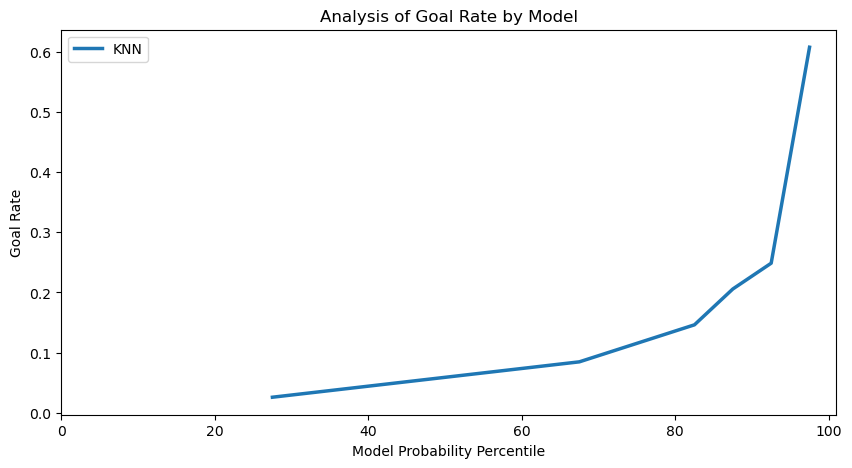

In [24]:
other_ml_models.generate_goal_rate_plot("KNN", df_prob_bined, experiment)

### Cumulative Goal Analysis

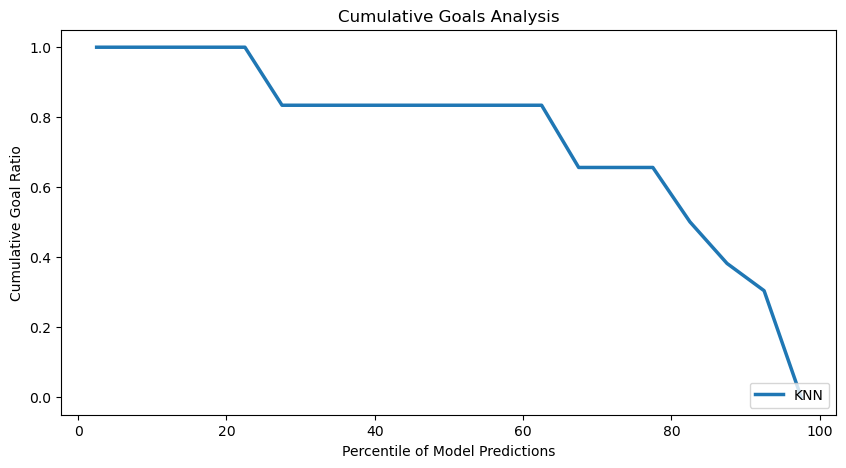

In [27]:
other_ml_models.visualize_cumulative_goals("KNN", df_prob_bined, experiment)

### Calibration curve

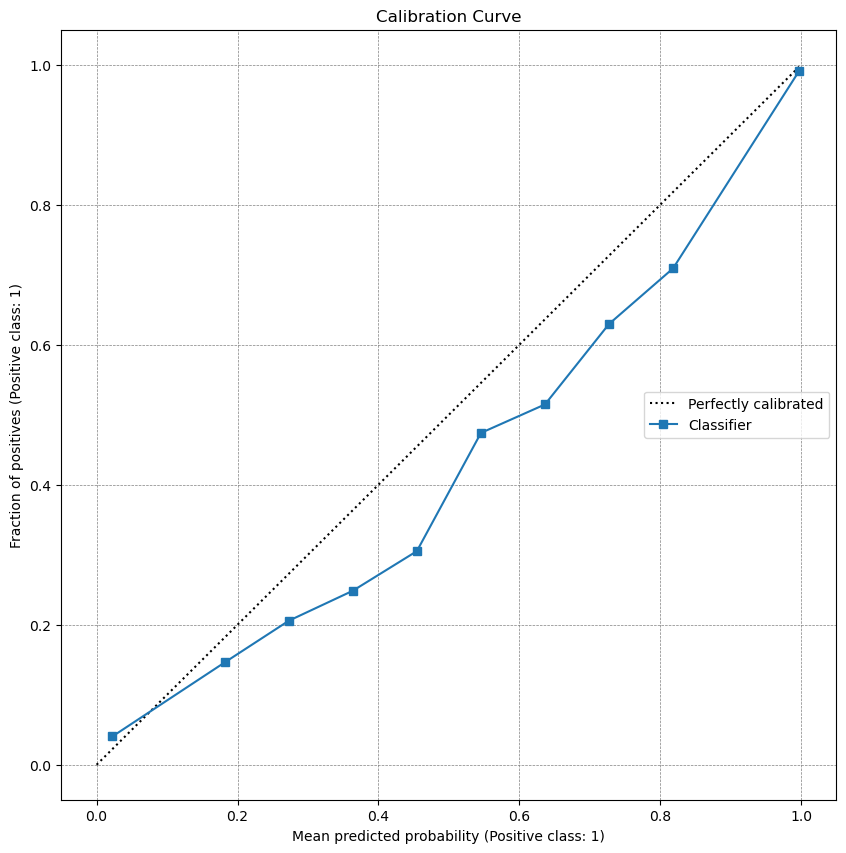

In [26]:
other_ml_models.plot_calibration_curve(y_test, preds_prob, experiment)

### Save Model

In [30]:
import pickle

In [31]:
if not os.path.exists('models/'):
    os.mkdir('models/')
    
pickle.dump(knn_pipe_best, open('models/KNN.sav', 'wb'))
experiment.log_model("MLP Clf", 'models/KNN.sav')

{'web': 'https://www.comet.com/api/asset/download?assetId=fbca8d67d6874a3b92bd8065fd5f9930&experimentKey=b80593d676374abb90be80dd5f748c5a',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=fbca8d67d6874a3b92bd8065fd5f9930&experimentKey=b80593d676374abb90be80dd5f748c5a',
 'assetId': 'fbca8d67d6874a3b92bd8065fd5f9930'}

In [32]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/mahmoodhegazy/nhl-data-science/b80593d676374abb90be80dd5f748c5a
COMET INFO:   Metrics:
COMET INFO:     accuracy  : 0.9243621347154626
COMET INFO:     f1        : 0.379965457685665
COMET INFO:     precision : 0.7570543702684102
COMET INFO:     recall    : 0.2536315425409269
COMET INFO:   Parameters:
COMET INFO:     model_type : Random Forest
COMET INFO:     param_grid : {'memory': None, 'steps': [('preprocessor', ColumnTransformer(transformers=[('Numerical_transform',
                                 Pipeline(steps=[('Impt', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
       